In [1]:
## Train a model to classify the images
#
## Import libraries

import os
import numpy as np

from tensorflow import keras
np.random.seed(0)

import src.config as config
from src.dataloader import read_train, read_val
from src.preprocessing import CustomDataGenerator
from src.results import plot_history, plot_cm, class_report,\
                            save_params, write_summary
from src.utils import setup_logger, header
import argparse
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


RAW_DATA_PATH = 'input/data/raw'
META_PATH = 'input/metadata/'

BATCH_SIZE = 64


#Readind data directly from the csv file and raw images in order to use data augmentation
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
df_labels['label'] = df_labels['label'].str.strip()
df_info = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
df_info["Medium"] = df_info["Medium"].str.strip()
df_load_data = df_info.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'Medium']]


datagen = ImageDataGenerator(
                                # rotation_range=30,        # Random rotation between -30 and 30 degrees
                                # width_shift_range=0.125,    # Random horizontal shifting (crop)
                                # height_shift_range=0.125,   # Random vertical shifting (crop)
                                # horizontal_flip=True,     # Randomly flip images horizontally
                                # rescale=1./255.,          # Rescale pixel values to the range [0, 1]
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation

)

val_datagen = ImageDataGenerator(#rescale=1./255.,
                                # preprocessing_function=lambda x: center_crop(x, 200, 200),
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation
)
# val_datagen.mean = 0.5
# val_datagen.std = 0.5

# val_datagen.mean = 0.5795
# val_datagen.std = 4.22
# df_load_data['id'] = df_load_data['id'].astype('str') # requires target in string format

train_generator_df = datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'train'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              seed=2020)

val_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              seed=2020)


test_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'],
                                                    directory=RAW_DATA_PATH,
                                                    x_col="Image file", 
                                                    y_col="Medium",
                                                    class_mode="sparse",
                                                    target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=2020)

y_val = val_generator_df.classes
labels = list(train_generator_df.class_indices.keys())

# model = keras.models.load_model('interesting/lr_2e-06_bs_128_ep_200/model.h5')

# model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])




2023-11-29 09:52:41.091408: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 09:52:41.198575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 09:52:41.839419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.


In [2]:
import umap
import time
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from src.preprocessing import CustomDataGenerator
from src.dataloader import read_train, read_val
import numpy as np

import keras
from src import config
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
# set cpu as available physical device
import tensorflow as tf


# X_train, y_train = read_train()
# X_val, y_val = read_val()

# X_train = X_train[:5000]


INPUT_SHAPE = (config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)
model = keras.applications.EfficientNetB0(weights="imagenet", 
                                 include_top=True)

extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
resize_layer = keras.layers.Resizing(224, 224, interpolation='bilinear', name='resize')
preprocess_input_layer = keras.layers.Lambda(preprocess_input, name='preprocess_input')
extractor = keras.Sequential([
    resize_layer,
    preprocess_input_layer,
    extractor
])

extractor(train_generator_df[0][0])

def get_features(X, extractor):
    # loader = CustomDataGenerator(X, y, batch_size=32)
    features = extractor.predict(X)
    return features

X_train_features = get_features(train_generator_df, extractor)
X_val_features = get_features(val_generator_df, extractor)

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-29 09:52:50.395461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 09:52:50.452047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 09:52:50.452192: I tensorflow/compi

23/23 [==============================] - 3s 111ms/step


In [3]:
y_train = train_generator_df.classes
y_val = val_generator_df.classes

In [37]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import xgboost as xgb

# use xgboost as the model with gpu support
rf = xgb.XGBClassifier(tree_method='hist', device="cuda", n_jobs=-1, )


umap_pipe = umap.UMAP(n_components=16)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('rf', rf)
])

pipe.fit(X_train_features, y_train)

y_pred = pipe.predict(X_val_features)
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc}")

# X_train_prep = umap_pipe.fit_transform(X_train_features, train_generator_df.classes)
# X_val_prep = umap_pipe.transform(X_val_features)

# rf = xgb.XGBClassifier(tree_method='hist', device="cuda", n_jobs=-1, )
# rf.fit(X_train_prep, train_generator_df.classes)

# y_pred = rf.predict(X_val_prep)
# acc = accuracy_score(y_val, y_pred)
# print(f"Accuracy: {acc}")

Accuracy: 0.6448275862068965


In [4]:
def combine_features(model, metadata, dataflow):
    
    features = model.predict(dataflow)
    df_features = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
    df_features['id'] = dataflow.filenames
    df_data = metadata.merge(df_features, left_on='Image file', right_on='id')
    df_data.drop(columns=['Image file', 'Medium', 'Museum-based instance ID',	'Subset', 'id'], inplace=True)
    return df_data

X_train = combine_features(extractor, df_info, train_generator_df)
X_val = combine_features(extractor, df_info, val_generator_df)


23/23 [==============================] - 2s 106ms/step


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train_prep = X_train.copy()
scaler = StandardScaler()
cat_feats = ['Museum']
num_feats = ['Width', 'Height', 'Product size', 'Aspect ratio']
ext_feats = [col for col in X_train_prep.columns if 'feature' in col]
X_train_prep[num_feats + ext_feats] = scaler.fit_transform(X_train_prep[num_feats + ext_feats])

umap_prep = umap.UMAP(n_components=8, random_state=0)
new_ext_feats = [f'umap_{i}' for i in range(8)]
X_train_prep[new_ext_feats] = umap_prep.fit_transform(X_train_prep[ext_feats], y_train)
X_train_prep.drop(columns=ext_feats, inplace=True)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train_prep[cat_feats])
ohe_feats = pd.DataFrame(ohe.transform(X_train_prep[cat_feats]), columns=ohe.get_feature_names_out(cat_feats))
X_train_prep = pd.concat([X_train_prep[num_feats + new_ext_feats], ohe_feats], axis=1)

X_val_prep = X_val.copy()
X_val_prep[num_feats + ext_feats] = scaler.transform(X_val_prep[num_feats + ext_feats])
X_val_prep[new_ext_feats] = umap_prep.transform(X_val_prep[ext_feats])
X_val_prep.drop(columns=ext_feats, inplace=True)
ohe_val_feats = pd.DataFrame(ohe.transform(X_val_prep[cat_feats]), columns=ohe.get_feature_names_out(cat_feats))
X_val_prep = pd.concat([X_val_prep[num_feats + new_ext_feats], pd.DataFrame(ohe_val_feats)], axis=1)

# X_train_prep = X_train_prep.values
# X_val_prep = X_val_prep.values

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_3965/1790720197.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_prep[new_ext_feats] = umap_prep.fit_transform(X_train_prep[ext_feats], y_train)
/tmp/ipykernel_3965/1790720197.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

In [6]:
X_train_prep.head()

,Width,Height,Product size,Aspect ratio,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,Museum_Los Angeles County Museum of Art,Museum_Metropolitan Museum of Art,Museum_The Cleveland Museum of Art
0,0.202226,0.539276,0.146502,-0.436728,10.589469,5.836817,1.891891,-0.769283,6.617920,7.693574,5.705904,-2.843238,0.0,1.0,0.0
1,-0.705919,-0.524759,-0.518485,-0.477038,10.464174,5.806087,1.941005,-0.744659,6.842807,7.781142,5.557673,-2.986625,0.0,1.0,0.0
2,0.013266,0.521167,0.049386,-0.585979,10.511103,5.866276,1.958881,-0.726817,6.719921,7.705152,5.606718,-2.884268,0.0,1.0,0.0
3,0.623752,-0.037701,0.070739,0.572476,10.523549,6.069855,2.037591,-0.826631,6.536740,7.414675,5.640276,-2.480054,0.0,1.0,0.0
4,0.623752,-0.547863,-0.174965,1.624058,10.698749,6.288493,2.048621,-0.936088,6.239405,7.280401,5.867867,-2.510390,0.0,1.0,0.0


In [8]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import pandas as pd
import xgboost as xgb

# use xgboost as the model with gpu support
clf = xgb.XGBClassifier(tree_method='hist', device="cuda", n_jobs=-1, )
# clf = RandomForestClassifier(n_jobs=-1, verbose=1)
umap_pipe = umap.UMAP(n_components=16)
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('umap', umap_pipe),
#     ('rf', clf)
# ])

clf.fit(X_train_prep, y_train)

y_pred = clf.predict(X_val_prep)
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.6151724137931035


<BarContainer object of 15 artists>

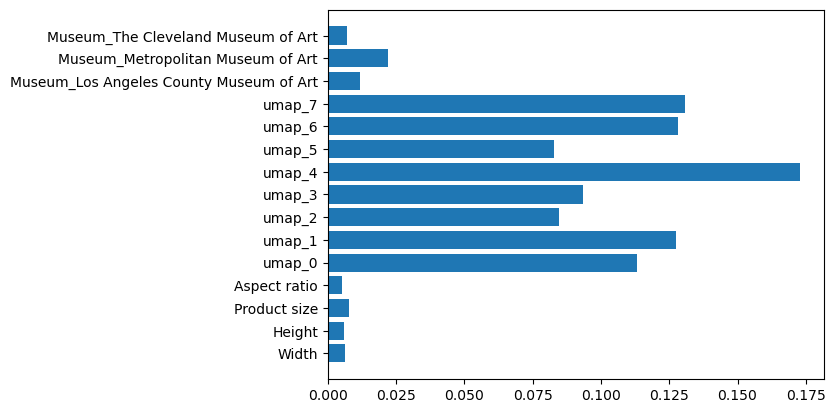

In [9]:
plt.barh(y=X_train_prep.columns, width=clf.feature_importances_)

In [50]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
import xgboost as xgb

# use xgboost as the model with gpu support
# clf = xgb.XGBClassifier(tree_method='hist', device="cuda", n_jobs=-1, )
clf = LogisticRegression(n_jobs=-1, verbose=1)
# clf = RandomForestClassifier(n_jobs=-1, verbose=1)
umap_pipe = umap.UMAP(n_components=16)
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('umap', umap_pipe),
#     ('rf', clf)
# ])

clf.fit(X_train_prep, y_train)

y_pred = clf.predict(X_val_prep)
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          464     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83561D+04    |proj g|=  5.52415D+03


 This problem is unconstrained.



At iterate   50    f=  1.27680D+04    |proj g|=  2.73974D+02

At iterate  100    f=  1.20359D+04    |proj g|=  1.25688D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  464    100    103      1     0     0   1.257D+02   1.204D+04
  F =   12035.861988509751     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.6020689655172414


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<BarContainer object of 15 artists>

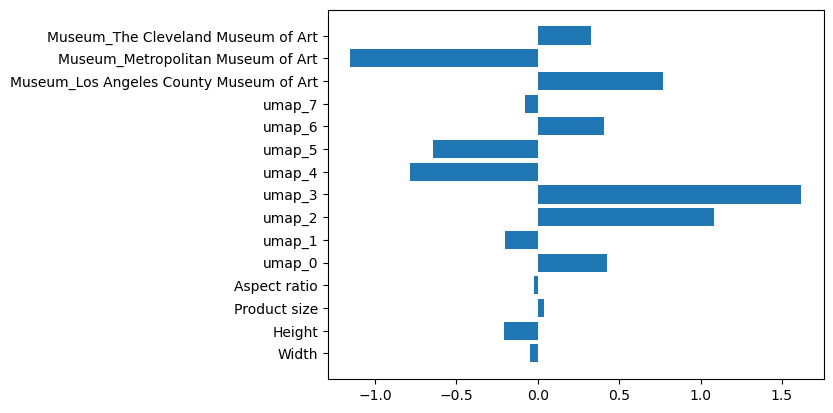

In [51]:
# plot coefficients
plt.barh(y=X_train_prep.columns, width=clf.coef_[1])



In [47]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 1,100,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        # 'n_estimators' : hp.quniform('n_estimators', 100, 180, 10),
        'n_estimators': hp.quniform("n_estimators", 100, 1000, 100),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']),
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), device="cuda", n_jobs=-1)

    umap_pipe = umap.UMAP(n_components=16)

    # pipe = Pipeline([
    #                 ('scaler', StandardScaler()),
    #                 ('umap', umap_pipe),
    #                 ('clf', clf)])

    
    clf.fit(X_train_prep, y_train)
    

    pred = clf.predict(X_val_prep)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [48]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

SCORE:                                                
0.5896551724137931                                    
SCORE:                                                                           
0.593103448275862                                                                
SCORE:                                                                           
0.5882758620689655                                                              
SCORE:                                                                          
0.5882758620689655                                                              
SCORE:                                                                          
0.5827586206896552                                                              
SCORE:                                                                          
0.5848275862068966                                                              
SCORE:                                                                       

In [49]:
best_hyperparams

{'colsample_bytree': 0.8625376114107686,
 'gamma': 7.539478247852607,
 'max_depth': 4.0,
 'min_child_weight': 7.0,
 'n_estimators': 500.0,
 'reg_alpha': 29.0,
 'reg_lambda': 0.07302388275646665}

In [3]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import xgboost as xgb

# use xgboost as the model with gpu support
rf = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1)


umap_pipe = umap.UMAP(n_components=16)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__min_samples_leaf': [1, 5, 10],
    # 'umap__n_components': [2, 4, 8, 16, 32, 64, 128]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_features, y_train)

best_params = grid.best_params_

df_results = pd.DataFrame(grid.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


2023-11-28 22:21:05.411592: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:21:05.442720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:21:05.451074: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:21:05.491642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tenso